# XAI Tutorial 4: EigenCAM

## Overview
In this tutorial, we will discuss the following topics:
* [Basic Pipeline Visualization](#tx04pipeline)
* [Extracting Intermediate Layer Outputs](#tx04outputs)
* [EigenCAM](#tx04eigen)

First let's get some imports out of the way:

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import fastestimator as fe
from fastestimator import Network, Pipeline, Estimator
from fastestimator.dataset.data import horse2zebra
from fastestimator.op.numpyop.multivariate import Resize
from fastestimator.op.numpyop.univariate import Normalize, ReadImage
from fastestimator.op.tensorop.model import ModelOp
from fastestimator.trace.io import ImageViewer
from fastestimator.trace.xai import EigenCAM
from fastestimator.util import ImgData

<a id='tx04pipeline'></a>

## Example Data and Pipeline

For this tutorial we will use some pictures of zebras with minimal pre-processing. Let's visualize some of the images to see what we're working with.

In [2]:
train_data, eval_data = horse2zebra.load_data(batch_size=5)
test_data = eval_data.split(range(5))  # We will just use the first 5 images for our visualizations
pipeline = Pipeline(test_data=test_data, 
                    ops=[ReadImage(inputs="B", outputs="B"), 
                         Resize(image_in="B", image_out="B", height=224, width=224),
                         Normalize(inputs="B", outputs="B", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
                        ])

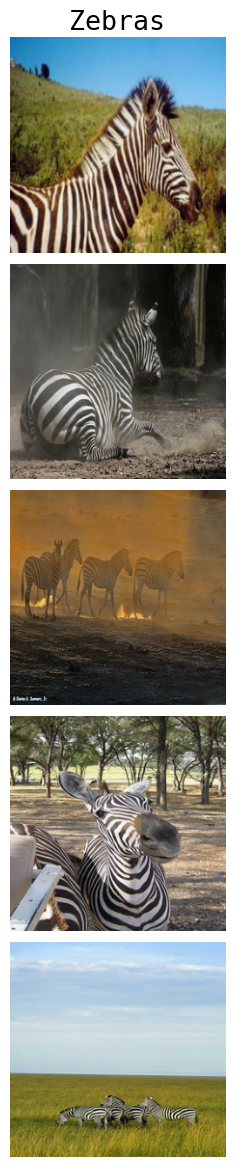

In [3]:
batch = pipeline.get_results(mode='test')
images = ImgData(Zebras=tf.convert_to_tensor(batch['B']))
fig = images.paint_figure()
plt.show()

<a id='tx04outputs'></a>

## Extracting Intermediate Layer Outputs

We will use a pre-trained ResNet151 model for this example, with standard ImageNet weights. We will inspect the model to decide which layer we want to analyze with EigenCAM.

In [4]:
model = fe.build(model_fn=lambda: tf.keras.applications.ResNet152V2(weights="imagenet"), optimizer_fn="adam")
print("\n".join([f"{idx}: {x.name}" for idx, x in enumerate(model._flatten_layers(include_self=False, recursive=True))]))

0: input_1
1: conv1_pad
2: conv1_conv
3: pool1_pad
4: pool1_pool
5: conv2_block1_preact_bn
6: conv2_block1_preact_relu
7: conv2_block1_1_conv
8: conv2_block1_1_bn
9: conv2_block1_1_relu
10: conv2_block1_2_pad
11: conv2_block1_2_conv
12: conv2_block1_2_bn
13: conv2_block1_2_relu
14: conv2_block1_0_conv
15: conv2_block1_3_conv
16: conv2_block1_out
17: conv2_block2_preact_bn
18: conv2_block2_preact_relu
19: conv2_block2_1_conv
20: conv2_block2_1_bn
21: conv2_block2_1_relu
22: conv2_block2_2_pad
23: conv2_block2_2_conv
24: conv2_block2_2_bn
25: conv2_block2_2_relu
26: conv2_block2_3_conv
27: conv2_block2_out
28: conv2_block3_preact_bn
29: conv2_block3_preact_relu
30: conv2_block3_1_conv
31: conv2_block3_1_bn
32: conv2_block3_1_relu
33: conv2_block3_2_pad
34: conv2_block3_2_conv
35: conv2_block3_2_bn
36: conv2_block3_2_relu
37: max_pooling2d
38: conv2_block3_3_conv
39: conv2_block3_out
40: conv3_block1_preact_bn
41: conv3_block1_preact_relu
42: conv3_block1_1_conv
43: conv3_block1_1_bn
44: 

This model has quite a few layers to choose from. We will try the avg_pool layer at the end

In [5]:
network = Network(ops=[
    ModelOp(model=model, inputs="B", outputs=["y_pred", "embedding"], intermediate_layers='post_relu'),
])

<a id='tx04eigen'></a>

## EigenCAM

Now it's time to generate some EiganCAM images. You can read more about this method [here](https://arxiv.org/abs/2008.00299). In short, this is a CAM method that only considers the principal components of convolution layer feature representations rather than the actual outputs of a model. As such it does not require any gradients, and is relatively blind to adversarial perturbation.

In [6]:
traces = [
        EigenCAM(images="B", activations="embedding", preds="y_pred"),
        ImageViewer(inputs="eigencam", mode="test")
    ]

estimator = Estimator(pipeline=pipeline,
                      network=network,
                      traces=traces,
                      epochs=1,
                     )

FastEstimator-Warn: the key 'A' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.


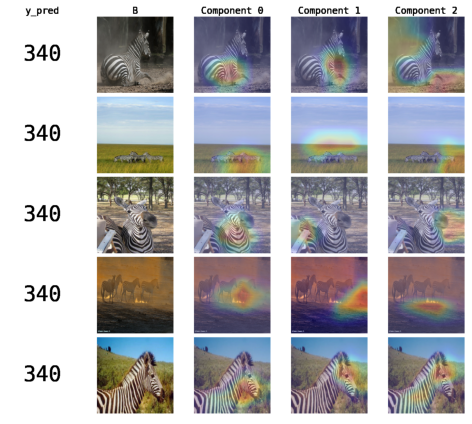

FastEstimator-Test: step: None; epoch: 1;


In [7]:
estimator.test()

ImageNet class 340 refers to zebras, so the model is correct for all of our data here. We can also see through the EigenCAM output that the model does seem to be focused on the zebra as the largest principal component of the feature output. It is interesting to note, though, that for several images the second or third principal components are focused more on background regions adjacent to zebras. Let's compare this with an untrained model:

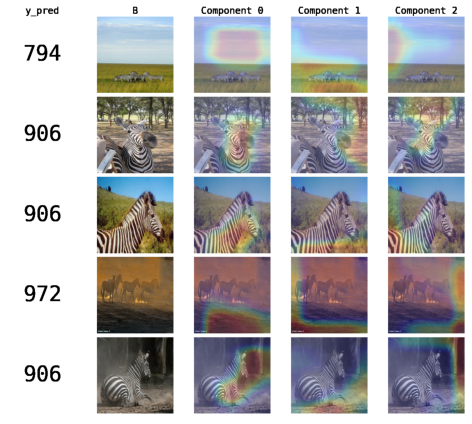

FastEstimator-Test: step: None; epoch: 1;


In [8]:
model = fe.build(model_fn=lambda: tf.keras.applications.ResNet152V2(weights=None), optimizer_fn="adam")
network = Network(ops=[
    ModelOp(model=model, inputs="B", outputs=["y_pred", "embedding"], intermediate_layers='post_relu'),
])
traces = [
        EigenCAM(images="B", activations="embedding", preds="y_pred"),
        ImageViewer(inputs="eigencam", mode="test")
    ]

estimator = Estimator(pipeline=pipeline,
                      network=network,
                      traces=traces,
                      epochs=1,
                     )
estimator.test()

As we can see from the images above, the untrained model does happen to focus on zebra-adjacent areas when the zebras take up a large percentage of the image (convolution layers are natural edge detectors), but in images where the zebras are further away / smaller the untrained network has no idea where to focus. It is good to keep in mind, however, that for some images even completely untrained models can appear to be looking in approximately the correct location.